## Get Single Event Data from BL4A 

Version 1.3

T. Charlton

M.R. Fitzsimmons

06.22.2020

Added report of mean proton charge per spin state.

Added dictionary functionality.

06.28.2020 Add process variable for MAGH

## This Notebook demonstrates how to obtain single event mode data.
This notebook needs to be run on analysis.sns.gov.  The files once written can be transferred to a local machine for further processing.

    1) Load a nexus event file.
    2) Obtains per pulse proton charge for each event.
    3) Removes proton flash.
    4) Filter events based on polarization state.
    5) Write information in text and python binary files.

## Code to import required libraries (run in a Mantid compatible kernal)

In [83]:
import os
%cd ~
cwd_path = os.getcwd()
print('Current working directory: %s'%cwd_path)

import sys, math, getopt, glob, operator
import numpy as np
import numpy.ma as ma 
np.warnings.filterwarnings('ignore')
import mantid
from mantid.simpleapi import *
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mantid import plots
from datetime import datetime


/SNS/users/mf3
Current working directory: /SNS/users/mf3


## Load nexus file data. 
    1) User provides directory path to IPTS experiment.
    2) User provides run number.
    3) User provides output file name.

In [84]:
#directory_path = cwd_path+r'/data/SNS/REF_M/IPTS-23100/' # user input
#run_number = '32400' # user input
#output_file_base = '32400_events' # user input do not add an extension

#IPTS-21391
#directory_path = cwd_path+r'/data/SNS/REF_M/IPTS-21391/' # user input
#run_number = '35097' # user input
#output_file_base = '35097_events' # user input do not add an extension

#IPTS-24314
directory_path = cwd_path+r'/data/SNS/REF_M/IPTS-24314/' # user input
run_number = '34638'
output_file_base = '34638_events' # user input do not add an extension

InputFile = directory_path+r'nexus/REF_M_'+run_number+'.nxs.h5'
print('Processing: %s'%InputFile)
OutputFile = directory_path+r'shared/'+output_file_base
print('Output file w/o extension: %s'%OutputFile)

if InputFile == None:
    # usage();   sys.exit()
    print("You should provide the name of a valid input file if you wish to continue...")
else:
    RawEvents=LoadEventNexus(InputFile)
    RawEvents=Rebin(RawEvents, "2e4, 1., 6e4", PreserveEvents=True) # so that we can plot things in more that one time bin

Processing: /SNS/users/mf3/data/SNS/REF_M/IPTS-24314/nexus/REF_M_34638.nxs.h5
Output file w/o extension: /SNS/users/mf3/data/SNS/REF_M/IPTS-24314/shared/34638_events


## Remove the proton flash 
Frequency is the frequency of the proton source.
Width is the size of the window of data to be expunged in microseconds.

In [85]:
NoProtonFlash=RemovePromptPulse(RawEvents, Width=300,Frequency=60.0)

## Show the images before and after proton flash removal.

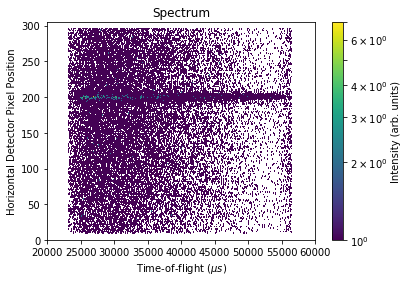

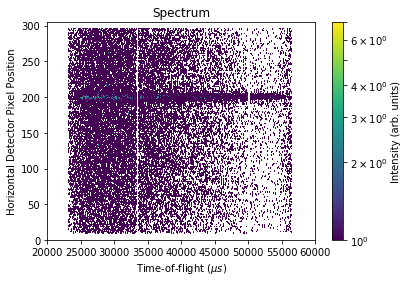

In [86]:
GroupByColumn = CreateGroupingWorkspace(InputWorkspace=RawEvents,FixedGroupCount=304,ComponentName='detector1')
ThetaGrouped = GroupDetectors(RawEvents,CopyGroupingFromWorkspace="GroupByColumn")

# Before
fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
plt.title('Before proton flash removal, Run: '+run_number)
c = ax.pcolormesh(ThetaGrouped, norm=LogNorm()) # 
cbar=fig.colorbar(c)
cbar.set_label('Intensity (arb. units)') #add text to colorbar
plt.ylabel('Horizontal Detector Pixel Position')

# After
GroupByColumn = CreateGroupingWorkspace(InputWorkspace=NoProtonFlash,FixedGroupCount=304,ComponentName='detector1')
ThetaGrouped = GroupDetectors(NoProtonFlash,CopyGroupingFromWorkspace="GroupByColumn")

fig, ax = plt.subplots(subplot_kw={'projection':'mantid'})
plt.title('After protorn flash removal Run: '+run_number)
c = ax.pcolormesh(ThetaGrouped, norm=LogNorm()) # , norm=LogNorm()
cbar=fig.colorbar(c)
cbar.set_label('Intensity (arb. units)') #add text to colorbar
plt.ylabel('Horizontal Detector Pixel Position')
plt.show()

## Get the proton charge per pulse and the absolute time for each pulse.


In [87]:
pc_values = NoProtonFlash.getRun()['proton_charge'].value
pc_times = NoProtonFlash.getRun()['proton_charge'].times

## Isolate the polarized beam cross sections

In [88]:
def filter_cross_sections(ws):
    """
        Filter events according to an aggregated state log.
        :param str file_path: file to read

        BL4A:SF:ICP:getDI

        015 (0000 1111): SF1=OFF, SF2=OFF, SF1Veto=OFF, SF2Veto=OFF
        047 (0010 1111): SF1=ON, SF2=OFF, SF1Veto=OFF, SF2Veto=OFF
        031 (0001 1111): SF1=OFF, SF2=ON, SF1Veto=OFF, SF2Veto=OFF
        063 (0011 1111): SF1=ON, SF2=ON, SF1Veto=OFF, SF2Veto=OFF
        
        From Mathieu Doucet.
    """
    state_log = "BL4A:SF:ICP:getDI"
    states = {'Off_Off': 15,
              'On_Off': 47,
              'Off_On': 31,
              'On_On': 63}
    cross_sections = []
    cross_sections_dict = {}

    for pol_state in states:
        try:
            _ws = FilterByLogValue(InputWorkspace=ws, 
                                   LogName=state_log, 
                                   TimeTolerance=0.1,
                                   MinimumValue=states[pol_state],
                                   MaximumValue=states[pol_state],
                                   LogBoundary='Left',
                                   OutputWorkspace='%s_%s'%(ws.getRunNumber(),
                                                            pol_state))
            _ws.getRun()['cross_section_id'] = pol_state
            if _ws.getNumberEvents() > 0:
                cross_sections.append(_ws)
                cross_sections_dict[pol_state] =_ws
        except:
            mantid.logger.error("Could not filter %s: %s"%(pol_state,
                                                           sys.exc_info()[1]))

    return cross_sections, cross_sections_dict


## Calculate the mean proton charge over the entire measurement.
Needs to be done now in order to filter for bad frames when the acquistion period is different than the accelerator period.

In [89]:
# Filter flipper states
(ListOfFilteredCrossSections,DictOfFilteredCrossSections)=filter_cross_sections(NoProtonFlash)
# Note: Since the list and the dictionary point to the same set of 
#       Mantid workspaces, changing one will change the other.
    
# Calculate mean proton charge over entire measurement in order to filter out outliers
   
if True:   # Choose your way to calculate the mean
      #True.  = > Use numpy
    # Exclude pc values corresponding to zero which occur often if not running at 60Hz, or not running
    _index = np.argwhere(pc_values>0)
    mean_pc = np.mean(pc_values[_index])
    rms_width = np.std(pc_values[_index])
        
else: # False => Use method below
    charge_sum = np.double(0.)
    charge2_sum = np.double(0.)
    n_sum = np.int32(0)
    for K in DictOfFilteredCrossSections.keys(): # As long as we don't  
                                                 # care about what order   
                                                 # we take the cross sections
                                                 # in we can do this.
        for x in range(256*304):
            f=DictOfFilteredCrossSections[K].getSpectrum(x) # spectrum for a single pixel vs. time
            tofs=f.getTofs(); PulseTimes = f.getPulseTimes(); 
            for i in range(f.getNumberEvents()): 
                t = mantid.kernel.DateAndTime(PulseTimes[i]).to_datetime64()
                _index = np.searchsorted(pc_times, t)
                charge = pc_values[_index]
                charge_sum = charge_sum + charge
                charge2_sum = charge2_sum + charge*charge
                n_sum = n_sum + 1
    mean_pc = charge_sum/n_sum # mean per pulse
    rms_width = np.sqrt((charge2_sum-2*mean_pc*charge_sum+n_sum*mean_pc*mean_pc)/(n_sum-1))
print('Mean and standard deviation of per pulse proton current: %.1f +/- %.1f'%(mean_pc,rms_width))

Mean and standard deviation of per pulse proton current: 23109158.2 +/- 68333.8


## Write out the event list to individual text files
Delete frames having a proton charge different by +/- n*sigma

In [90]:
# PulseTimes is the time of the proton t0.
# tofs is the neutron time of flight after the t0 of the same frame

n_sig = 4 # accept events for frames having proton charge within 4-sigma
for K in DictOfFilteredCrossSections.keys(): 
    OFile = open(OutputFile+'_%s.txt'%(K), 'w')
    print('Writing: '+OutputFile+'_%s.txt'%(K))
    OutList =[] ; OutStrings=[]
    for x in range(256*304):
        f=DictOfFilteredCrossSections[K].getSpectrum(x) # spectrum for a single pixel vs. time
        tofs=f.getTofs(); PulseTimes = f.getPulseTimes(); 
        for i in range(f.getNumberEvents()): 
            t = mantid.kernel.DateAndTime(PulseTimes[i]).to_datetime64()
            _index = np.searchsorted(pc_times, t)
            charge = pc_values[_index]
            dt64 = np.datetime64(pc_times[_index])
# OutList contains n-events defined by absolute time of t0 in ns and string forms, tof (micro-s), pixel-id, proton charge
# Here apply filter, only append if within 1-sigma of mean proton charge
            if np.abs(charge-mean_pc) < n_sig/2*rms_width:        
                OutList.append((dt64.astype(datetime),tofs[i], x, charge))
                OutStrings.append("%s\t%.10f\t%d\t%.10f\n"%(PulseTimes[i],
                                   tofs[i], x, charge))    
    OutStrings.sort()
    for item in OutStrings: 
        OFile.write(item)
    OFile.close()
    OutList.sort()    
    t0_time = np.zeros(len(OutList), dtype=np.uint64)
    t0_time_string = []
    tof = np.zeros(len(OutList), dtype=np.float32)
    pixel_id = np.zeros(len(OutList), dtype=np.uint32)
    pcharge = np.zeros(len(OutList), dtype=np.float32)
    for i in range(len(OutList)):
        x = OutList[i]
        t0_time[i] = x[0]
        t0_time_string.append(np.datetime64(x[0],'ns'))
        tof[i] = x[1]
        pixel_id[i] = x[2]
        pcharge[i] = x[3]    
    np.savez(OutputFile+'_%s.npz'%(K),t0_time,t0_time_string,tof,pixel_id,pcharge)

Writing: /SNS/users/mf3/data/SNS/REF_M/IPTS-24314/shared/34638_events_On_Off.txt
Writing: /SNS/users/mf3/data/SNS/REF_M/IPTS-24314/shared/34638_events_Off_Off.txt


## Write (r,twotheta,phi) coordinates of each pixel and some slow log data.


In [91]:
RunInfo=RawEvents.getRun()

instrument = RawEvents.getInstrument()

source = instrument.getSource()
sample = instrument.getSample()
Parameters = instrument.getParameterNames() # this lives in the 
                                            # Mantid Instrument 
                                            # Parameter file.
Source_Sample_Distance = sample.getDistance(source) # m
Det=instrument.getDetector(int(256*304/2))  # distance from sample to center of detector
Sample_Detector_Center_Distance = Det.getDistance(sample) # m


pixel_to_coordinate = np.zeros((256*304,3), dtype=np.float32)

for i in range(256*304):
    Det=instrument.getDetector(i)  # i is the detetector element index
    PixelPos = Det.getPos()
    pixel_to_coordinate[i,0]= Det.getDistance(sample) # m
    pixel_to_coordinate[i,1]= np.arctan(float(PixelPos[0])/float(PixelPos[2])) # radians
    pixel_to_coordinate[i,2]= np.arctan(float(PixelPos[1])/float(PixelPos[2])) # radians

# Use to print out all choices of parameters in log files
#for i in range(484):
#    print(RunInfo.keys()[i])
#OutStrings2 = []

print('Source to sample distance: %s [m]'%Source_Sample_Distance)
OutStrings2.append('Source to sample distance: %s [m]\n'%Source_Sample_Distance)

print('Sample to PSD center distance: %s [m]'%Sample_Detector_Center_Distance)
OutStrings2.append('Sample to PSD center distance: %s [m]\n'%Sample_Detector_Center_Distance)

TemperatureLog= RunInfo.getLogData('BL4A:SE:Lakeshore:KRDG1')
print('Mean temperature: %.2f(%.2f) [K]'%(np.mean(TemperatureLog.value[:]),np.std(TemperatureLog.value[:])))
OutStrings2.append('Mean temperature: %.2f(%.2f) [K]\n'%(np.mean(TemperatureLog.value[:]),np.std(TemperatureLog.value[:])))

DANGLELog=RunInfo.getLogData('DANGLE')
print('Detector angle: %.2f(%.2f) [degrees]'%(np.mean(DANGLELog.value[:]),np.std(DANGLELog.value[:])))
OutStrings2.append('Detector angle: %.2f(%.2f) [degrees]\n'%(np.mean(DANGLELog.value[:]),np.std(DANGLELog.value[:])))

DANGLE0Log=RunInfo.getLogData('DANGLE0')
print('Detector offset angle: %.2f(%.2f) [degrees]'%(np.mean(DANGLE0Log.value[:]),np.std(DANGLE0Log.value[:])))
OutStrings2.append('Detector offset angle: %.2f(%.2f) [degrees]\n'%(np.mean(DANGLE0Log.value[:]),np.std(DANGLE0Log.value[:])))

SANGLELog=RunInfo.getLogData('SANGLE')
print('Sample angle: %.2f(%.2f) [degrees]'%(np.mean(SANGLELog.value[:]),np.std(SANGLELog.value[:])))
OutStrings2.append('Sample angle: %.2f(%.2f) [degrees]\n'%(np.mean(SANGLELog.value[:]),np.std(SANGLELog.value[:])))

C0Log= RunInfo.getLogData('BL4A:CS:ExpPlan:DirectPixel')
print('Direct Beam Pixel: %s'%np.mean(C0Log.value[:]))
OutStrings2.append('Direct Beam Pixel: %s\n'%np.mean(C0Log.value[:]))

ChopperFreqLog= RunInfo.getLogData('BL4A:Chop:Gbl:Speed:Req')
print('Chopper Frequency: %s [Hz]'%np.mean(ChopperFreqLog.value[:]))
OutStrings2.append('Chopper Frequency: %s [Hz]\n'%np.mean(ChopperFreqLog.value[:]))

LambdaBarLog= RunInfo.getLogData('BL4A:Chop:Gbl:Wavelength:Req')
print('Mean wavelength: %s [Angstroms]'%np.mean(LambdaBarLog.value[:]))
OutStrings2.append('Mean wavelength: %s [Angstroms]\n'%np.mean(LambdaBarLog.value[:]))

EMagLog= RunInfo.getLogData('BL4A:SE:Bruker:FieldSP')
print('Electromagnet induction: %.4f (%.4f) [T]'%(np.mean(EMagLog.value[:]),np.std(EMagLog.value[:])))
OutStrings2.append('Electromagnet induction: %.4f (%.4f) [T]\n'%(np.mean(EMagLog.value[:]),np.std(EMagLog.value[:])))

try:
    MagHSPLog= RunInfo.getLogData('BL4A:SE:MagH:SP')
    print('MagH induction (set point): %.4f (%.4f) [T]'%(np.mean(MagHSPLog.value[:]),np.std(MagHSPLog.value[:])))
    OutStrings2.append('MagH induction (set point): %.4f (%.4f) [T]\n'%(np.mean(MagHSPLog.value[:]),np.std(MagHSPLog.value[:])))
    MagHLog= RunInfo.getLogData('BL4A:SE:MagH:ReadField')
    print('MagH induction (actual): %.4f (%.4f) [T]'%(np.mean(MagHLog.value[:]),np.std(MagHLog.value[:])))
    OutStrings2.append('MagH induction (actual): %.4f (%.4f) [T]\n'%(np.mean(MagHLog.value[:]),np.std(MagHLog.value[:])))
    MagH = True
    
except RuntimeError:
    print('No MagH process variable in nexus file.')
    MagH = False # new S.E. not all files have this variable

OFile = open(OutputFile+'_log.txt', 'w')
print('Writing: '+OutputFile+'_log.txt')
for item in OutStrings2: 
    OFile.write(item)
OFile.close()

if MagH:
    np.savez(OutputFile+'_log.npz',pixel_to_coordinate,
             Source_Sample_Distance,
             Sample_Detector_Center_Distance,
             TemperatureLog.times,TemperatureLog.value,
             DANGLELog.times,DANGLELog.value,
             DANGLE0Log.times,DANGLE0Log.value,
             SANGLELog.times,SANGLELog.value,
             C0Log.times,C0Log.value,
             ChopperFreqLog.times,ChopperFreqLog.value,
             LambdaBarLog.times,LambdaBarLog.value,
             EMagLog.times,EMagLog.value,
             MagHSPLog.times,MagHSPLog.value,
             MagHLog.times,MagHLog.value)
else:
    np.savez(OutputFile+'_log.npz',pixel_to_coordinate,
             Source_Sample_Distance,
             Sample_Detector_Center_Distance,
             TemperatureLog.times,TemperatureLog.value,
             DANGLELog.times,DANGLELog.value,
             DANGLE0Log.times,DANGLE0Log.value,
             SANGLELog.times,SANGLELog.value,
             C0Log.times,C0Log.value,
             ChopperFreqLog.times,ChopperFreqLog.value,
             LambdaBarLog.times,LambdaBarLog.value,
             EMagLog.times,EMagLog.value)


Source to sample distance: 18.703 [m]
Sample to PSD center distance: 2.29874686732 [m]
Mean temperature: 309.90(0.00) [K]
Detector angle: 0.00(0.00) [degrees]
Detector offset angle: 0.80(0.00) [degrees]
Sample angle: 0.00(0.00) [degrees]
Direct Beam Pixel: 200.0
Chopper Frequency: 30.0 [Hz]
Mean wavelength: 7.5 [Angstroms]
Electromagnet induction: 0.0000 (0.0000) [T]
No MagH process variable in nexus file.
Writing: /SNS/users/mf3/data/SNS/REF_M/IPTS-24314/shared/34638_events_log.txt


In [93]:
RunInfo.keys()

['start_time',
 'end_time',
 'Analyzer',
 'AnalyzerLabel',
 'AnalyzerLift',
 'AnalyzerLiftRequest',
 'AnalyzerRot',
 'AnalyzerRotRequest',
 'AnalyzerState',
 'AnalyzerTrans',
 'AnalyzerTransRequest',
 'AnalyzerVeto',
 'BDetSlit',
 'BDetSlitRequest',
 'BL4A:CS:ARConfig:AnalyzerLabel',
 'BL4A:CS:ARConfig:AnalyzerSel',
 'BL4A:CS:ARConfig:DataType',
 'BL4A:CS:ARConfig:PolarizerLabel',
 'BL4A:CS:ARConfig:PolarizerSel',
 'BL4A:CS:ARConfig:Sequence:Id',
 'BL4A:CS:ARConfig:Sequence:Num',
 'BL4A:CS:ARConfig:Sequence:Total',
 'BL4A:CS:ExpPlan:DANGLE0',
 'BL4A:CS:ExpPlan:DirectPixel',
 'BL4A:CS:ITEMS',
 'BL4A:CS:ITEMS:CanBarcode',
 'BL4A:CS:ITEMS:CanIndicator',
 'BL4A:CS:ITEMS:CanMaterials',
 'BL4A:CS:ITEMS:CanName',
 'BL4A:CS:ITEMS:Comments',
 'BL4A:CS:ITEMS:Component',
 'BL4A:CS:ITEMS:Container',
 'BL4A:CS:ITEMS:ContainerId',
 'BL4A:CS:ITEMS:Density',
 'BL4A:CS:ITEMS:DensityUnits',
 'BL4A:CS:ITEMS:Description',
 'BL4A:CS:ITEMS:Formula',
 'BL4A:CS:ITEMS:HeightInContainer',
 'BL4A:CS:ITEMS:Height

In [96]:
print(RunInfo.getLogData('BL4A:SE:MagneticField'))

RuntimeError: Unknown property search object BL4A:SE:MagneticField

In [97]:
print(RunInfo.getLogData('BL4A:SE:SampleTemp'))

RuntimeError: Unknown property search object BL4A:SE:SampleTemp

In [98]:
RunNo=34638; LoadEventNexus(OutputWorkspace='r%d'%(RunNo),Filename='REF_M_%d'%(RunNo))
r34638 = mtd['r%d'%(RunNo)]
Run=r34638.getRun()
str(Run['BL4A:SE:SampleTemp'].nthTime(0)), Run['BL4A:SE:SampleTemp'].nthValue(0)
str(Run['BL4A:SE:MagneticField'].nthTime(0)), Run['BL4A:SE:MagneticField'].nthValue(0)

RuntimeError: Unknown property search object BL4A:SE:SampleTemp

In [109]:
RunNo=34668; LoadEventNexus(OutputWorkspace='r%d'%(RunNo),Filename='REF_M_%d'%(RunNo))

EventWorkspace
Title: Data Runs Sample 1 B = 4.7T 2K
Histograms: 77824
Bins: 1
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: REF_M (2000-Dec-19 to 2100-Jan-31)Instrument from: /SNS/users/mf3/data/SNS/REF_M/IPTS-21391/nexus/REF_M_35097.nxs.h5

Parameters from: /SNS/software/miniconda2/envs/py2-mantid-nightly/instrument/REF_M_Parameters.xml
Run start: 2020-Feb-12 16:47:16
Run end:  2020-Feb-12 16:59:31

Events: 581640

In [110]:
r34668 = mtd['r%d'%(RunNo)]

In [111]:
Run=r34668.getRun()

In [112]:
str(Run['BL4A:SE:SampleTemp'].nthTime(0)), Run['BL4A:SE:SampleTemp'].nthValue(0)

RuntimeError: Unknown property search object BL4A:SE:SampleTemp

In [113]:
str(Run['BL4A:SE:MagneticField'].nthTime(0)), Run['BL4A:SE:MagneticField'].nthValue(0)

RuntimeError: Unknown property search object BL4A:SE:MagneticField